# Install dependenceies and import packages:

In [ ]:
!pip install --pre astroquery[all]
!pip install git+https://github.com/KrishnaswamyLab/CATCH

In [3]:
from tensorflow.test import gpu_device_name
gpu_device_name()

''

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import sys

###### For Catch/Machine learning
import graphtools
from CATCH import catch
import matplotlib.pyplot as plt
import scprep

import phate
import sklearn
from sklearn.cluster import KMeans

import tasklogger
import collections
import warnings
from collections import defaultdict

from scipy.spatial.distance import pdist, cdist, squareform
warnings.simplefilter("ignore")

###### For the astronomy data
# import astropy.units as u
# from astropy.coordinates.sky_coordinate import SkyCoord
# from astropy.units import Quantity
# from astroquery.gaia import Gaia

## Some helper functions I wrote
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project')
from astro_dc_utils import *

# Load Necib accreted stars data

In [6]:
Stars = pd.read_hdf('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/Public_SelectedByNetwork_6D.h5')

In [7]:
Stars = Stars.sample(6000)
print(Stars)

                  source_id           l          b          ra        dec  \
150795  3576876909030521088  293.899717  50.968017  187.069104 -11.497092   
2209    6716031117988282880  353.361238 -17.828060  282.543555 -42.791182   
66994   5916160052593624832  333.119811 -11.811235  260.383662 -57.815289   
416380  6211146755882680320  336.662036  22.804723  229.249972 -30.369593   
126272  4432424567510447744   17.972022  31.119606  248.723055   2.234110   
...                     ...         ...        ...         ...        ...   
145848  4572416518262865152   44.988400  35.016959  254.479717  24.449964   
138042   345217209123355904  138.070916 -19.176945   32.065884  41.425365   
381501  5467044943159700224  263.000603  24.122252  152.232983 -25.881220   
427658  1062674900164777600  131.073144  44.974074  174.934633  71.003681   
240512  6435698297634804992  325.359995 -21.280281  271.759212 -68.759260   

        parallax        pmra       pmdec  phot_g_mean_mag  phot_bp_mean_mag

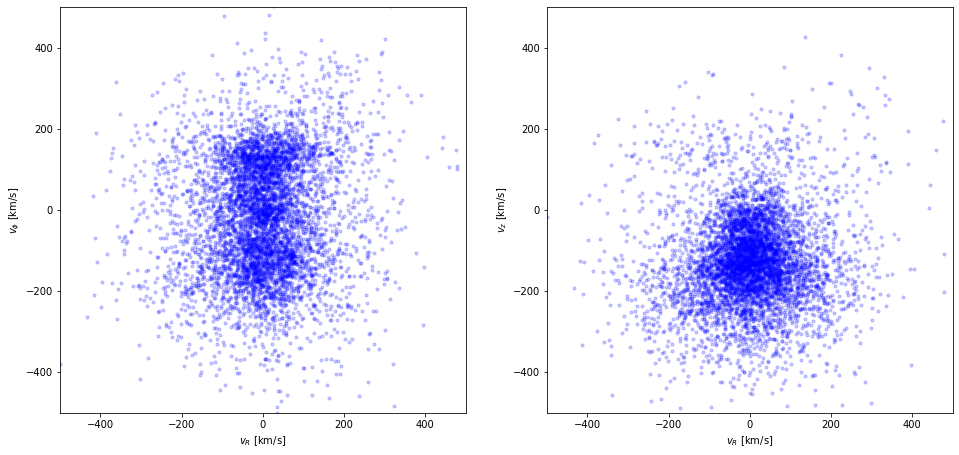

In [8]:
#convert the pmra and pmdec to velocities in km/s
au_yr = 1.49598e+8 / 3.15576e+7
pmra_to_kms = (Stars['pmra']/Stars['parallax']) * au_yr
pmdec_to_kms = (Stars['pmdec']/Stars['parallax']) * au_yr

vs = [pmra_to_kms, pmdec_to_kms]
ylabels = ['$v_\phi$ [km/s]', '$v_z$ [km/s]'] #Check these!


#Plot 
fig, axes = plt.subplots(1,2, figsize=(16, 8))

for i, ax in enumerate(axes.flatten()):
  ax.scatter(Stars['radial_velocity'], vs[i], color='b', alpha=0.2, s=10)
  ax.set_xlim(-500, 500)
  ax.set_ylim(-500, 500)
  ax.set_aspect('equal')
  ax.set_xlabel('$v_R$ [km/s]')
  ax.set_ylabel(ylabels[i])

In [10]:
X = Stars[['pmra', 'pmdec', 'radial_velocity', 'parallax', 'l', 'b']]
print(X)

              pmra       pmdec  radial_velocity  parallax           l  \
150795  -19.648128  -20.943691       -38.289781  0.966872  293.899717   
2209    -29.990194  -62.112666       166.726582  0.961635  353.361238   
66994    -2.805112  -36.774302        -9.211906  0.495433  333.119811   
416380   -5.810860  -27.049779       281.905303  0.608308  336.662036   
126272   -0.580896  -20.128435       -29.005192  0.341680   17.972022   
...            ...         ...              ...       ...         ...   
145848   -0.999476  -25.572735      -111.389465  0.360450   44.988400   
138042   43.538155  -25.815381        83.805338  1.888277  138.070916   
381501    7.594554  -13.457608       125.292782  0.453732  263.000603   
427658 -187.993134 -299.316898         4.121352  4.421764  131.073144   
240512   -5.006257  -25.273005       118.012292  0.581835  325.359995   

                b  
150795  50.968017  
2209   -17.828060  
66994  -11.811235  
416380  22.804723  
126272  31.119606  
...

In [11]:
catch_op = catch.CATCH(knn=20, random_state=18, n_pca=2, n_jobs=1)
catch_op.fit(X)

Calculating PCA...
Calculated PCA in 0.04 seconds.
Calculating Diffusion Condensation...
  Calculating Condensation Parameters...
  Calculated Condensation Parameters in 0.89 seconds.
Calculated Diffusion Condensation in 62.00 seconds.


Calculating Topological Activity...
[-28]


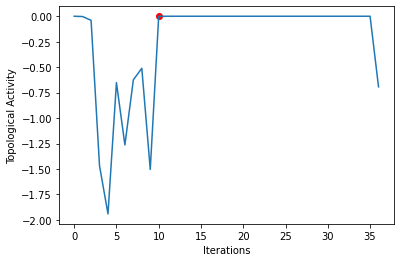

<Figure size 432x288 with 0 Axes>

In [22]:
#visualize topology
visualize_topology(catch_op, topological_activity=True, trees=False)
plt.savefig('topological_activity')

Calculating Topological Activity...


IndexError: ignored

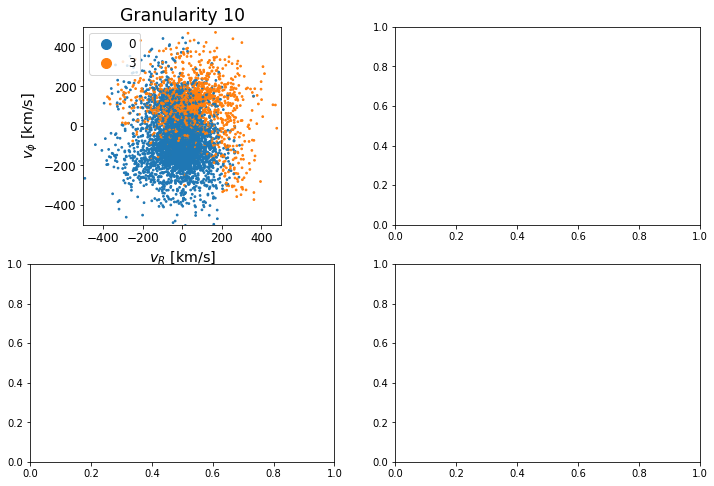

In [23]:
#visualize granularities
levels = catch_op.transform()
custom_levels = [0]

for j in range(2):
    fig, axes = plt.subplots(2,2, figsize=(12, 8))
    for i, ax in enumerate(axes.flatten()):
        if custom_levels != None:
            lev = levels[custom_levels[i]]
        else:
            lev = levels[-2*i-1]

        scprep.plot.scatter2d(np.column_stack((Stars['radial_velocity'], vs[j])), c=catch_op.NxTs[lev], ax=ax, title='Granularity '+str(len(catch_op.NxTs)+lev), xticks=True, yticks=True, label_prefix="PM", fontsize=10, s=3)
        ax.set_xlim(-500, 500)
        ax.set_ylim(-500, 500)
        ax.set_aspect('equal')
        ax.set_xlabel('$v_R$ [km/s]')
        ax.set_ylabel(ylabels[j])
    